# Data preprocessing

In [1]:
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import re

# Preprocessing
def prepocessing(lyrics, remove_stopwords=False, stops=set(stopwords.words('english'))):
    lyric_text = BeautifulSoup(lyric, "html5lib").get_text()
    lyric_text = re.sub("[^a-zA-Z]", " ", lyric_text)
    lyric_text = lyric_text.lower()
    
    lyric_words = lyric_text.split()
    if remove_stopwords:
        lyric_words = lyric_text.split()
        lyric_words = [w for w in lyric_words if not w in stops]
        
    lyric_text = ' '.join(lyric_words)
    return lyric_text

In [2]:
# Create dataset

import pandas as pd
import tqdm

df = pd.read_csv('./preprocessed_train_data.csv')

df.head(5)

,Genre,Lyrics
0,Rock,it starts with pain followed by hate fueled by...
1,Rock,freedom alone again again alone patiently wait...
2,Rock,biting the hand that feeds you lying to the vo...
3,Rock,you say you know just who i am but you can t i...
4,Rock,my heart is beating faster can t control these...


In [3]:
processed_lyrics = []
for lyric in tqdm.tqdm(df['Lyrics'].values):
    processed = prepocessing(lyric, remove_stopwords=True)
    processed_lyrics.append(processed)

100%|████████████████████████████████████████████████████████████████████████| 249943/249943 [01:55<00:00, 2161.60it/s]


# Build Word2vec model by skip-gram and negative sampling
- Followed Tensroflow tutorial
- Vocabulary size : 4096
- Sequence length :10
- number of negative sample : 4

In [4]:
import os
import re
import string
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

In [5]:
%load_ext tensorboard

In [6]:
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

In [9]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
    # Elements of each training example are appended to these lists.
    targets, contexts, labels = [], [], []

    # Build the sampling table for vocab_size tokens.
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

    # Iterate over all sequences (sentences) in dataset.
    for sequence in tqdm.tqdm(sequences):

        # Generate positive skip-gram pairs for a sequence (sentence).
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
              sequence,
              vocabulary_size=vocab_size,
              sampling_table=sampling_table,
              window_size=window_size,
              negative_samples=0)

        # Iterate over each positive skip-gram pair to produce training examples
        # with positive context word and negative samples.
        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(tf.constant([context_word], dtype="int64"), 1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
              true_classes=context_class,
              num_true=1,
              num_sampled=num_ns,
              unique=True,
              range_max=vocab_size,
              seed=SEED,
              name="negative_sampling")

            # Build context and label vectors (for one target word)
            negative_sampling_candidates = tf.expand_dims(
                negative_sampling_candidates, 1)

            context = tf.concat([context_class, negative_sampling_candidates], 0)
            label = tf.constant([1] + [0]*num_ns, dtype="int64")

            # Append each element from the training example to global lists.
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)

    return targets, contexts, labels

In [14]:
# Now, create a custom standardization function to lowercase the text and
# remove punctuation.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation), '')


# Define the vocabulary size and number of words in a sequence.
vocab_size = 4096
sequence_length = 10
num_ns = 4

# Use the TextVectorization layer to normalize, split, and map strings to
# integers. Set output_sequence_length length to pad all samples to same length.
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

In [12]:
vectorize_layer.adapt(processed_lyrics)

In [13]:
# Save the created vocabulary for reference.
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])

['', '[UNK]', 'love', 'know', 'like', 'oh', 'got', 'get', 'go', 'one', 'let', 'time', 'baby', 'see', 'never', 'yeah', 'want', 'come', 'say', 'cause']


In [14]:
ds = tf.data.Dataset.from_tensor_slices(processed_lyrics)

In [15]:
# Vectorize the data in text_ds.
text_vector_ds = ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()

In [16]:
sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))

249943


In [16]:
for seq in sequences[:5]:
    print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

[   8  959   31  275 2475   99  367    1   99    4] => ['it', 'starts', 'with', 'pain', 'followed', 'by', 'hate', '[UNK]', 'by', 'the']
[ 846  165  117  117  165 3435  254   99    4  577] => ['freedom', 'alone', 'again', 'again', 'alone', 'patiently', 'waiting', 'by', 'the', 'phone']
[  1   4 211  14   1   3 857   5   4 570] => ['[UNK]', 'the', 'hand', 'that', '[UNK]', 'you', 'lying', 'to', 'the', 'voice']
[  3  68   3  28  32  97   2 141  30   3] => ['you', 'say', 'you', 'know', 'just', 'who', 'i', 'am', 'but', 'you']
[  12   88   23 1190 1246   21   11  466  156  820] => ['my', 'heart', 'is', 'beating', 'faster', 'can', 't', 'control', 'these', 'feelings']


In [17]:
# Generate train data for training word2vec.

targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=3,
    num_ns=num_ns,
    vocab_size=vocab_size,
    seed=SEED)

targets = np.array(targets)
contexts = np.array(contexts)[:,:,0]
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

100%|█████████████████████████████████████████████████████████████████████████| 249943/249943 [28:34<00:00, 145.79it/s]




targets.shape: (1681813,)
contexts.shape: (1681813, 5)
labels.shape: (1681813, 5)


In [20]:
import pickle

BATCH_SIZE = 1024
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))

# save processed dataset for re-use.
with open('word2vec_train.pickle', 'wb') as f:
    pickle.dump(((targets, contexts), labels), f)
    
print(dataset)

<TensorSliceDataset shapes: (((), (5,)), (5,)), types: ((tf.int64, tf.int64), tf.int64)>


In [12]:
# Load pickle file
import pickle

BATCH_SIZE = 1024
BUFFER_SIZE = 10000

with open('word2vec_train.pickle', 'rb') as f:
    dataset = pickle.load(f)
    
dataset = tf.data.Dataset.from_tensor_slices(dataset)

In [13]:
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True) # shuffle and batch.

# Define Word2vec model

In [16]:
class Word2Vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.target_embedding = layers.Embedding(vocab_size,
                                          embedding_dim,
                                          input_length=1,
                                          name="w2v_embedding")
        self.context_embedding = layers.Embedding(vocab_size,
                                           embedding_dim,
                                           input_length=num_ns+1)

    def call(self, pair):
        target, context = pair
        # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
        # context: (batch, context)
        if len(target.shape) == 2:
            target = tf.squeeze(target, axis=1)
        # target: (batch,)
        word_emb = self.target_embedding(target)
        # word_emb: (batch, embed)
        context_emb = self.context_embedding(context)
        # context_emb: (batch, context, embed)
        dots = tf.einsum('be,bce->bc', word_emb, context_emb)
        # dots: (batch, context)
        return dots

In [23]:
def custom_loss(x_logit, y_true):
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

# Experiment 1: Embedding dimesion 128

In [24]:
embedding_dim = 128
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    verbose=1,
    patience=3
)

learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='accuracy',
    patience=3,
    verbose=1,
    factor=0.25,
    min_lr=0.0000001
)

In [26]:
history = word2vec.fit(dataset, epochs=200, callbacks=[tensorboard_callback, earlystop, learning_rate])

Epoch 1/200
1642/1642 [==============================] - 16s 8ms/step - loss: 1.4082 - accuracy: 0.3897 - lr: 0.0010
Epoch 2/200
1642/1642 [==============================] - 14s 8ms/step - loss: 1.2649 - accuracy: 0.4761 - lr: 0.0010
Epoch 3/200
1642/1642 [==============================] - 13s 8ms/step - loss: 1.1751 - accuracy: 0.5262 - lr: 0.0010
Epoch 4/200
1642/1642 [==============================] - 13s 8ms/step - loss: 1.1092 - accuracy: 0.5601 - lr: 0.0010
Epoch 5/200
1642/1642 [==============================] - 13s 8ms/step - loss: 1.0577 - accuracy: 0.5852 - lr: 0.0010
Epoch 6/200
1642/1642 [==============================] - 14s 8ms/step - loss: 1.0159 - accuracy: 0.6049 - lr: 0.0010
Epoch 7/200
1642/1642 [==============================] - 14s 8ms/step - loss: 0.9814 - accuracy: 0.6209 - lr: 0.0010
Epoch 8/200
1642/1642 [==============================] - 13s 8ms/step - loss: 0.9525 - accuracy: 0.6338 - lr: 0.0010
Epoch 9/200
1642/1642 [==============================] - 14s 9ms

1642/1642 [==============================] - 13s 8ms/step - loss: 0.6246 - accuracy: 0.7613 - lr: 0.0010
Epoch 140/200
1642/1642 [==============================] - 13s 8ms/step - loss: 0.6242 - accuracy: 0.7614 - lr: 0.0010
Epoch 141/200
1642/1642 [==============================] - 13s 8ms/step - loss: 0.6239 - accuracy: 0.7615 - lr: 0.0010
Epoch 142/200
1642/1642 [==============================] - 13s 8ms/step - loss: 0.6236 - accuracy: 0.7617 - lr: 0.0010
Epoch 143/200
1642/1642 [==============================] - 13s 8ms/step - loss: 0.6233 - accuracy: 0.7617 - lr: 0.0010
Epoch 144/200
1642/1642 [==============================] - 13s 8ms/step - loss: 0.6230 - accuracy: 0.7617 - lr: 0.0010
Epoch 145/200
1642/1642 [==============================] - 13s 8ms/step - loss: 0.6227 - accuracy: 0.7618 - lr: 0.0010
Epoch 146/200
1642/1642 [==============================] - 13s 8ms/step - loss: 0.6223 - accuracy: 0.7619 - lr: 0.0010
Epoch 147/200
1642/1642 [==============================] - 13s

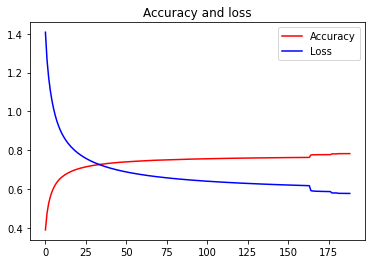

<Figure size 432x288 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt

%matplotlib inline
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Accuracy')
plt.plot(epochs, loss, 'b', label='Loss')
plt.title('Accuracy and loss')
plt.legend()
plt.figure()

plt.show()

In [30]:
word2vec.save('word2vec_exp1')

INFO:tensorflow:Assets written to: word2vec_exp1\assets


# Experiment2 : Embedding dimesion 300

In [18]:
embedding_dim = 300
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [19]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    verbose=1,
    patience=3
)

learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='accuracy',
    patience=3,
    verbose=1,
    factor=0.25,
    min_lr=0.0000001
)

In [20]:
history = word2vec.fit(dataset, epochs=200, callbacks=[tensorboard_callback, earlystop, learning_rate])

Epoch 1/200
1642/1642 [==============================] - 16s 8ms/step - loss: 1.3748 - accuracy: 0.4131 - lr: 0.0010
Epoch 2/200
1642/1642 [==============================] - 14s 8ms/step - loss: 1.1884 - accuracy: 0.5211 - lr: 0.0010
Epoch 3/200
1642/1642 [==============================] - 13s 8ms/step - loss: 1.0694 - accuracy: 0.5838 - lr: 0.0010
Epoch 4/200
1642/1642 [==============================] - 13s 8ms/step - loss: 0.9776 - accuracy: 0.6290 - lr: 0.0010
Epoch 5/200
1642/1642 [==============================] - 15s 9ms/step - loss: 0.9033 - accuracy: 0.6631 - lr: 0.0010
Epoch 6/200
1642/1642 [==============================] - 13s 8ms/step - loss: 0.8423 - accuracy: 0.6900 - lr: 0.0010
Epoch 7/200
1642/1642 [==============================] - 14s 9ms/step - loss: 0.7917 - accuracy: 0.7115 - lr: 0.0010
Epoch 8/200
1642/1642 [==============================] - 13s 8ms/step - loss: 0.7493 - accuracy: 0.7288 - lr: 0.0010
Epoch 9/200
1642/1642 [==============================] - 13s 8ms

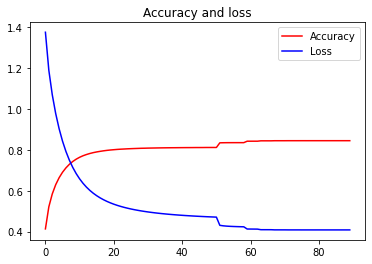

<Figure size 432x288 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Accuracy')
plt.plot(epochs, loss, 'b', label='Loss')
plt.title('Accuracy and loss')
plt.legend()
plt.figure()

plt.show()

In [22]:
word2vec.save('word2vec_exp2')

INFO:tensorflow:Assets written to: word2vec_exp2\assets


In [ ]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [ ]:
word2vec.get_layer('w2v_embedding')

In [103]:
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

# Classifier part
- Using RNN based model

Rock: 0
Pop: 1
Metal: 2
Jazz: 3
Folk: 4
Indie: 5
R&B: 6
Hip-Hop: 7
Electronic: 8
Country: 9

In [7]:
genre_idx = {
    'Rock': 0,
    'Pop': 1,
    'Metal': 2,
    'Jazz': 3,
    'Folk': 4,
    'Indie': 5,
    'R&B': 6,
    'Hip-Hop': 7,
    'Electronic': 8,
    'Country': 9,
}

In [8]:
# define data and label
x = processed_lyrics
y = []

for genre in df['Genre']:
    y.append(genre_idx[genre])

In [9]:
BUFFER_SIZE = 10000
BATCH_SIZE = 1024

train_ds = tf.data.Dataset.from_tensor_slices((x, y))
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    x, y, test_size=0.3, random_state=42
)

In [11]:
# class weight
num_data = []
total = len(x)

for genre in df['Genre'].unique():
    num_data.append(len(df[df['Genre'] == genre]))

print(num_data)

class_weight = {
    0: 1 - num_data[0] / total,
    1: 1 - num_data[1] / total,
    2: 1 - num_data[2] / total,
    3: 1 - num_data[3] / total,
    4: 1 - num_data[4] / total,
    5: 1 - num_data[5] / total,
    6: 1 - num_data[6] / total,
    7: 1 - num_data[7] / total,
    8: 1 - num_data[8] / total,
    9: 1 - num_data[9] / total
}

[107016, 19098, 86217, 7240, 8165, 2002, 2763, 13314, 2238, 1890]


In [14]:
for w in class_weight:
    print(f'{w}: {class_weight[w]}')

0: 0.5718383791504462
1: 0.9235905786519326
2: 0.6550533521642934
3: 0.9710333956142
4: 0.9673325518218153
5: 0.9919901737596172
6: 0.9889454795693418
7: 0.9467318548629088
8: 0.991045958478533
9: 0.9924382759269114


In [12]:
VOCAB_SIZE = 1000 # max numberof token
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_ds.map(lambda text, label: text))   

In [ ]:
class GenreClassifier(tf.keras.Model):
    
    def __init__(self):
        super(GenreClassifier, self).__init__()    
        self.encoder = encoder
        self.embed = my_word2vec.get_layer('w2v_embedding')
        self.lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.predict = tf.keras.layers.Dense(10, activation='softmax')
        
    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.embed(x)
        x = self.lstm(x)
        x = self.dense1(x)
        return self.predict(x)
    

# Experiment 1
- Bidirection LSTM 64 units -> Dense 64 units

In [54]:
model = tf.keras.Sequential([
    encoder,
    word2vec.get_layer('w2v_embedding'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [55]:
model.layers[0].trainable = False
model.layers[1].trainable = False

In [56]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [57]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model_2bidrection',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=4
)

learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.25,
    min_lr=0.0000001
)

In [58]:
history_classifier = model.fit(
    X_train, y_train, 
    epochs=50,           
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[earlystop, learning_rate],
    class_weight=class_weight
)

Epoch 1/50
5468/5468 [==============================] - 182s 33ms/step - loss: 1.0738 - accuracy: 0.5075 - val_loss: 1.2713 - val_accuracy: 0.5573 - lr: 1.0000e-04
Epoch 2/50
5468/5468 [==============================] - 175s 32ms/step - loss: 0.9979 - accuracy: 0.5536 - val_loss: 1.2581 - val_accuracy: 0.5566 - lr: 1.0000e-04
Epoch 3/50
5468/5468 [==============================] - 175s 32ms/step - loss: 0.9784 - accuracy: 0.5641 - val_loss: 1.2690 - val_accuracy: 0.5403 - lr: 1.0000e-04
Epoch 4/50
5468/5468 [==============================] - 175s 32ms/step - loss: 0.9653 - accuracy: 0.5698 - val_loss: 1.2124 - val_accuracy: 0.5776 - lr: 1.0000e-04
Epoch 5/50
5468/5468 [==============================] - 174s 32ms/step - loss: 0.9548 - accuracy: 0.5760 - val_loss: 1.2019 - val_accuracy: 0.5803 - lr: 1.0000e-04
Epoch 6/50
5468/5468 [==============================] - 175s 32ms/step - loss: 0.9468 - accuracy: 0.5788 - val_loss: 1.2048 - val_accuracy: 0.5781 - lr: 1.0000e-04
Epoch 7/50
5468/

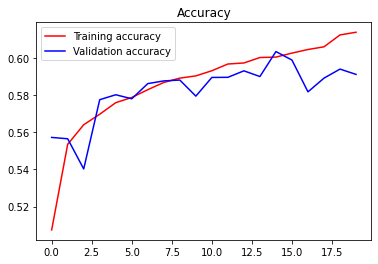

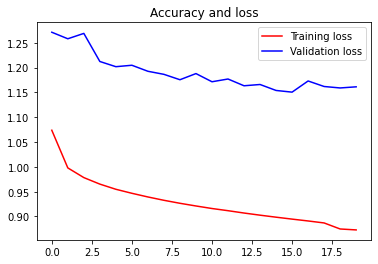

<Figure size 432x288 with 0 Axes>

In [59]:
import matplotlib.pyplot as plt

acc = history_classifier.history['accuracy']
loss = history_classifier.history['loss']
val_acc = history_classifier.history['val_accuracy']
val_loss = history_classifier.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Accuracy and loss')
plt.legend()
plt.figure()


plt.show()

In [60]:
model.save('experiment1-LSTM64')

INFO:tensorflow:Assets written to: experiment1-LSTM64\assets


INFO:tensorflow:Assets written to: experiment1-LSTM64\assets


# Experiment 2 (with 300 dim word2vec embedding)
- Bidirection LSTM 64 units -> Dense 64 units

In [34]:
model = tf.keras.Sequential([
    encoder,
    word2vec.get_layer('w2v_embedding'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [35]:
model.layers[0].trainable = False
model.layers[1].trainable = False

In [36]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [37]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model_2bidrection',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=4
)

learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.25,
    min_lr=0.0000001
)

In [38]:
history_classifier = model.fit(
    X_train, y_train, 
    epochs=50,           
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[earlystop, learning_rate],
    class_weight=class_weight
)

Epoch 1/50
5468/5468 [==============================] - 183s 33ms/step - loss: 1.0812 - accuracy: 0.5058 - val_loss: 1.2659 - val_accuracy: 0.5450 - lr: 1.0000e-04
Epoch 2/50
5468/5468 [==============================] - 177s 32ms/step - loss: 0.9853 - accuracy: 0.5602 - val_loss: 1.2231 - val_accuracy: 0.5710 - lr: 1.0000e-04
Epoch 3/50
5468/5468 [==============================] - 179s 33ms/step - loss: 0.9589 - accuracy: 0.5756 - val_loss: 1.2068 - val_accuracy: 0.5713 - lr: 1.0000e-04
Epoch 4/50
5468/5468 [==============================] - 183s 33ms/step - loss: 0.9418 - accuracy: 0.5836 - val_loss: 1.2028 - val_accuracy: 0.5760 - lr: 1.0000e-04
Epoch 5/50
5468/5468 [==============================] - 187s 34ms/step - loss: 0.9282 - accuracy: 0.5904 - val_loss: 1.1772 - val_accuracy: 0.5902 - lr: 1.0000e-04
Epoch 6/50
5468/5468 [==============================] - 196s 36ms/step - loss: 0.9170 - accuracy: 0.5959 - val_loss: 1.1719 - val_accuracy: 0.5908 - lr: 1.0000e-04
Epoch 7/50
5468/

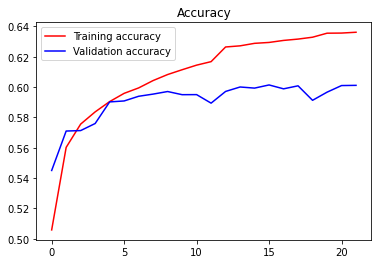

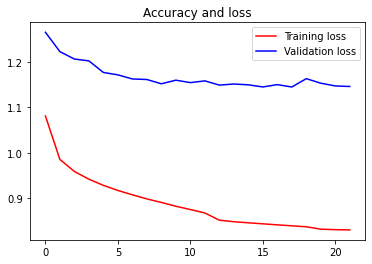

<Figure size 432x288 with 0 Axes>

In [39]:
import matplotlib.pyplot as plt

acc = history_classifier.history['accuracy']
loss = history_classifier.history['loss']
val_acc = history_classifier.history['val_accuracy']
val_loss = history_classifier.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Accuracy and loss')
plt.legend()
plt.figure()


plt.show()

In [40]:
model.save('experiment2-LSTM64')

INFO:tensorflow:Assets written to: experiment2-LSTM64\assets


INFO:tensorflow:Assets written to: experiment2-LSTM64\assets


# Experiment 2-2: 300 embedding dim with 2 bidriection layer

In [43]:
model = tf.keras.Sequential([
    encoder,
    word2vec.get_layer('w2v_embedding'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [46]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [47]:
history_classifier = model.fit(
    X_train, y_train, 
    epochs=50,           
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[earlystop, learning_rate],
    class_weight=class_weight
)

Epoch 1/50
5468/5468 [==============================] - 345s 62ms/step - loss: 1.0529 - accuracy: 0.5178 - val_loss: 1.2508 - val_accuracy: 0.5646 - lr: 1.0000e-04
Epoch 2/50
5468/5468 [==============================] - 332s 61ms/step - loss: 0.9729 - accuracy: 0.5671 - val_loss: 1.2175 - val_accuracy: 0.5706 - lr: 1.0000e-04
Epoch 3/50
5468/5468 [==============================] - 380s 69ms/step - loss: 0.9512 - accuracy: 0.5789 - val_loss: 1.1874 - val_accuracy: 0.5867 - lr: 1.0000e-04
Epoch 4/50
5468/5468 [==============================] - 408s 75ms/step - loss: 0.9333 - accuracy: 0.5873 - val_loss: 1.2030 - val_accuracy: 0.5604 - lr: 1.0000e-04
Epoch 5/50
5468/5468 [==============================] - 350s 64ms/step - loss: 0.9181 - accuracy: 0.5937 - val_loss: 1.2014 - val_accuracy: 0.5644 - lr: 1.0000e-04
Epoch 6/50
5467/5468 [============================>.] - ETA: 0s - loss: 0.9057 - accuracy: 0.5998
Epoch 00006: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
54

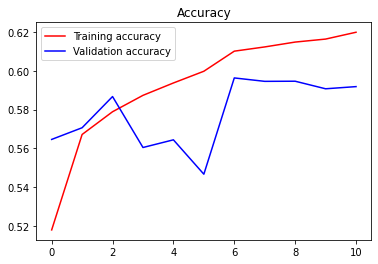

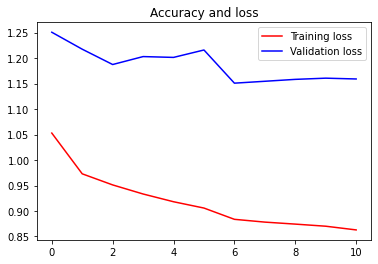

<Figure size 432x288 with 0 Axes>

In [48]:
import matplotlib.pyplot as plt

acc = history_classifier.history['accuracy']
loss = history_classifier.history['loss']
val_acc = history_classifier.history['val_accuracy']
val_loss = history_classifier.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Accuracy and loss')
plt.legend()
plt.figure()


plt.show()

In [49]:
model.save('experiment2-2bidriection')

INFO:tensorflow:Assets written to: experiment2-2bidriection\assets


INFO:tensorflow:Assets written to: experiment2-2bidriection\assets


# Experiment 2-2-1 One Bidirectional different class weight

In [22]:
class_weight = {
    0: (1 / num_data[0]) * (total / 10.0),
    1: (1 / num_data[1]) * (total / 10.0),
    2: (1 / num_data[2]) * (total / 10.0),
    3: (1 / num_data[3]) * (total / 10.0),
    4: (1 / num_data[4]) * (total / 10.0),
    5: (1 / num_data[5]) * (total / 10.0),
    6: (1 / num_data[6]) * (total / 10.0),
    7: (1 / num_data[7]) * (total / 10.0),
    8: (1 / num_data[8]) * (total / 10.0),
    9: (1 / num_data[9]) * (total / 10.0)
}

word2vec = tf.keras.models.load_model('word2vec_exp2')

model = tf.keras.Sequential([
    encoder,
    word2vec.get_layer('w2v_embedding'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.layers[0].trainable = False
model.layers[1].trainable = False

METRICS = [
    'accuracy',
#     tf.keras.metrics.TruePositives(name='tp'),
#     tf.keras.metrics.FalsePositives(name='fp'),
#     tf.keras.metrics.TrueNegatives(name='tn'),
#     tf.keras.metrics.FalseNegatives(name='fn'), 
#     tf.keras.metrics.Recall(name='recall'),
]

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=METRICS
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model_2bidrection',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=4
)

learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.25,
    min_lr=0.0000001
)

history_classifier = model.fit(
    X_train, y_train, 
    epochs=50,           
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[earlystop, learning_rate],
    class_weight=class_weight
)

Epoch 1/50
5468/5468 [==============================] - 208s 38ms/step - loss: 2.8180 - accuracy: 0.2818 - val_loss: 2.1052 - val_accuracy: 0.2690 - lr: 1.0000e-04
Epoch 2/50
5468/5468 [==============================] - 190s 35ms/step - loss: 2.6199 - accuracy: 0.2736 - val_loss: 2.0563 - val_accuracy: 0.2932 - lr: 1.0000e-04
Epoch 3/50
5468/5468 [==============================] - 199s 36ms/step - loss: 2.5413 - accuracy: 0.2797 - val_loss: 2.0012 - val_accuracy: 0.2847 - lr: 1.0000e-04
Epoch 4/50
5468/5468 [==============================] - 197s 36ms/step - loss: 2.4855 - accuracy: 0.2844 - val_loss: 1.9721 - val_accuracy: 0.2934 - lr: 1.0000e-04
Epoch 5/50
5468/5468 [==============================] - 189s 35ms/step - loss: 2.4342 - accuracy: 0.2857 - val_loss: 2.0283 - val_accuracy: 0.3073 - lr: 1.0000e-04
Epoch 6/50
5468/5468 [==============================] - 196s 36ms/step - loss: 2.3858 - accuracy: 0.2888 - val_loss: 2.0370 - val_accuracy: 0.2726 - lr: 1.0000e-04
Epoch 7/50
5468/

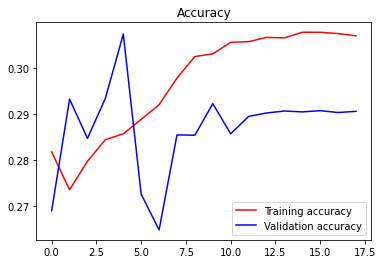

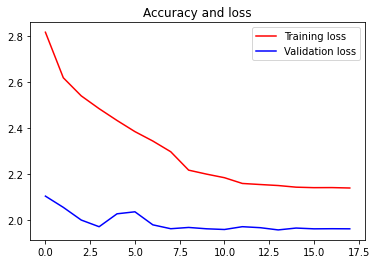

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt

acc = history_classifier.history['accuracy']
loss = history_classifier.history['loss']
val_acc = history_classifier.history['val_accuracy']
val_loss = history_classifier.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Accuracy and loss')
plt.legend()
plt.figure()


plt.show()

In [24]:
model.save('exp2-2-1')

INFO:tensorflow:Assets written to: exp2-2-1\assets


INFO:tensorflow:Assets written to: exp2-2-1\assets


# Experiment 2-2-2 Two Bidirectional different class weight

In [25]:
class_weight = {
    0: (1 / num_data[0]) * (total / 10.0),
    1: (1 / num_data[1]) * (total / 10.0),
    2: (1 / num_data[2]) * (total / 10.0),
    3: (1 / num_data[3]) * (total / 10.0),
    4: (1 / num_data[4]) * (total / 10.0),
    5: (1 / num_data[5]) * (total / 10.0),
    6: (1 / num_data[6]) * (total / 10.0),
    7: (1 / num_data[7]) * (total / 10.0),
    8: (1 / num_data[8]) * (total / 10.0),
    9: (1 / num_data[9]) * (total / 10.0)
}

word2vec = tf.keras.models.load_model('word2vec_exp2')

model = tf.keras.Sequential([
    encoder,
    word2vec.get_layer('w2v_embedding'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.layers[0].trainable = False
model.layers[1].trainable = False

METRICS = [
    'accuracy',
#     tf.keras.metrics.TruePositives(name='tp'),
#     tf.keras.metrics.FalsePositives(name='fp'),
#     tf.keras.metrics.TrueNegatives(name='tn'),
#     tf.keras.metrics.FalseNegatives(name='fn'), 
#     tf.keras.metrics.Recall(name='recall'),
]

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=METRICS
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model_2bidrection',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=4
)

learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.25,
    min_lr=0.0000001
)

history_classifier = model.fit(
    X_train, y_train, 
    epochs=50,           
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[earlystop, learning_rate],
    class_weight=class_weight
)

Epoch 1/50
5468/5468 [==============================] - 321s 58ms/step - loss: 2.7343 - accuracy: 0.2617 - val_loss: 2.0279 - val_accuracy: 0.2581 - lr: 1.0000e-04
Epoch 2/50
5468/5468 [==============================] - 317s 58ms/step - loss: 2.5696 - accuracy: 0.2731 - val_loss: 2.0212 - val_accuracy: 0.2585 - lr: 1.0000e-04
Epoch 3/50
5468/5468 [==============================] - 310s 57ms/step - loss: 2.4940 - accuracy: 0.2810 - val_loss: 2.0609 - val_accuracy: 0.2707 - lr: 1.0000e-04
Epoch 4/50
5468/5468 [==============================] - 299s 55ms/step - loss: 2.4347 - accuracy: 0.2885 - val_loss: 2.0444 - val_accuracy: 0.2722 - lr: 1.0000e-04
Epoch 5/50
5468/5468 [==============================] - 299s 55ms/step - loss: 2.3810 - accuracy: 0.2914 - val_loss: 1.9892 - val_accuracy: 0.3007 - lr: 1.0000e-04
Epoch 6/50
5468/5468 [==============================] - 305s 56ms/step - loss: 2.3310 - accuracy: 0.2977 - val_loss: 1.9618 - val_accuracy: 0.2897 - lr: 1.0000e-04
Epoch 7/50
5468/

In [30]:
acc = [0.2617, 0.2731, 0.2810, 0.2885, 0.2914, 0.2977, 0.2989, 0.3024, 0.3103, 0.3139, 0.3149, 0.3197, 0.3201, 0.3208, 0.3228, 0.3226, 0.3220, 0.3232, 0.3232, 0.3233]
loss = [2.7343, 2.5696, 2.4940, 2.4347, 2.3810, 2.3310, 2.2812, 2.2263, 2.1107, 2.0740, 2.0482, 2.0059, 1.9947, 1.9861, 1.9741, 1.9706, 1.9683, 1.9653, 1.9631, 1.9635]
val_acc = [0.2581, 0.2585, 0.2707, 0.2722, 0.3007, 0.2897, 0.2855, 0.2859, 0.2938, 0.2859, 0.2906, 0.2930, 0.2902, 0.2948, 0.2944, 0.2945, 0.2953, 0.2956, 0.2954, 0.2954]
val_loss = [2.0279, 2.0212, 2.0609, 2.0444, 1.9892, 1.9618, 2.0168, 1.9990, 1.9610, 1.9895, 1.9654, 1.9600, 1.9489, 1.9430, 1.9469, 1.9416, 1.9436, 1.9449, 1.9448, 1.9441]

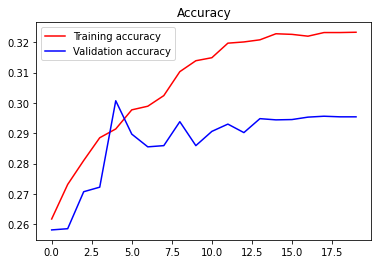

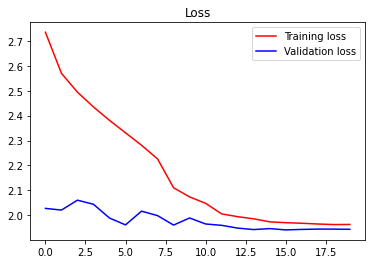

<Figure size 432x288 with 0 Axes>

In [32]:
import matplotlib.pyplot as plt

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Loss')
plt.legend()
plt.figure()


plt.show()

In [26]:
model.save('exp2-2-2')

INFO:tensorflow:Assets written to: exp2-2-2\assets


INFO:tensorflow:Assets written to: exp2-2-2\assets


# Experiment 2-2-3 Two Bidirectional LSTM without class weight

In [13]:
word2vec = tf.keras.models.load_model('word2vec_exp2')

model = tf.keras.Sequential([
    encoder,
    word2vec.get_layer('w2v_embedding'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.layers[0].trainable = False
model.layers[1].trainable = False

METRICS = [
    'accuracy',
#     tf.keras.metrics.TruePositives(name='tp'),
#     tf.keras.metrics.FalsePositives(name='fp'),
#     tf.keras.metrics.TrueNegatives(name='tn'),
#     tf.keras.metrics.FalseNegatives(name='fn'), 
#     tf.keras.metrics.Recall(name='recall'),
]

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=METRICS
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model_2bidrection',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=4
)

learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.25,
    min_lr=0.0000001
)

history_classifier = model.fit(
    X_train, y_train, 
    epochs=50,           
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[earlystop, learning_rate],
    class_weight=class_weight
)

Epoch 1/50
5468/5468 [==============================] - 323s 58ms/step - loss: 1.0452 - accuracy: 0.5243 - val_loss: 1.2522 - val_accuracy: 0.5505 - lr: 1.0000e-04
Epoch 2/50
5468/5468 [==============================] - 313s 57ms/step - loss: 0.9718 - accuracy: 0.5668 - val_loss: 1.2058 - val_accuracy: 0.5786 - lr: 1.0000e-04
Epoch 3/50
5468/5468 [==============================] - 312s 57ms/step - loss: 0.9489 - accuracy: 0.5784 - val_loss: 1.2000 - val_accuracy: 0.5734 - lr: 1.0000e-04
Epoch 4/50
5468/5468 [==============================] - 306s 56ms/step - loss: 0.9323 - accuracy: 0.5866 - val_loss: 1.1727 - val_accuracy: 0.5910 - lr: 1.0000e-04
Epoch 5/50
5468/5468 [==============================] - 304s 56ms/step - loss: 0.9184 - accuracy: 0.5936 - val_loss: 1.1788 - val_accuracy: 0.5823 - lr: 1.0000e-04
Epoch 6/50
5468/5468 [==============================] - 308s 56ms/step - loss: 0.9057 - accuracy: 0.5996 - val_loss: 1.1705 - val_accuracy: 0.5927 - lr: 1.0000e-04
Epoch 7/50
5468/

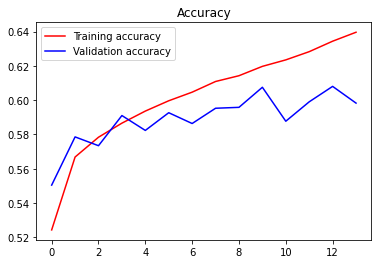

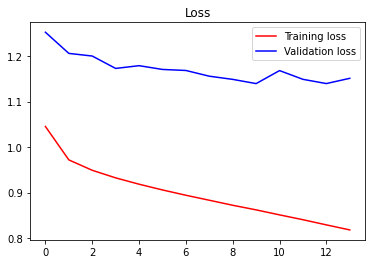

<Figure size 432x288 with 0 Axes>

In [34]:
import matplotlib.pyplot as plt

acc = history_classifier.history['accuracy']
loss = history_classifier.history['loss']
val_acc = history_classifier.history['val_accuracy']
val_loss = history_classifier.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Loss')
plt.legend()
plt.figure()


plt.show()

In [33]:
model.save('exp2-2-3')

INFO:tensorflow:Assets written to: exp2-2-3\assets


INFO:tensorflow:Assets written to: exp2-2-3\assets
